In [20]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
import os
from plotly import graph_objects as go
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
# df_orig = pd.read_csv("data-processed/rki-reports.csv")
df_apple = pd.read_csv("data-processed/data_apple_prepared.csv")
df_rki_orig = pd.read_csv('dash/data/data_rki_apple_prepared_dash.csv')
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')
# df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df_rki_orig['date']=df_rki_orig['date'].astype('datetime64[ns]')
df_rki_orig.index = df_rki_orig.date
df_jh_world['date']=df_jh_world['date'].astype('datetime64[ns]')
df_jh_world.index = df_jh_world.date

In [249]:
# df_rki_orig

In [194]:
df_orig.columns

Index(['date_index', 'date', 'land', 'confirmed', 'dead', 'name', 'iso_code',
       'capital', 'area', 'population', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead_avg3', 'dead_change',
       'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days

In [3]:
l = 'Bremen'
column = 'confirmed'
peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
df.loc[(df.index.isin(peak_index)) & (df.land == l), column]

date
2020-03-04      3
2020-04-19    585
Name: confirmed, dtype: int64

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def findpeak_trend(df):
    df_peak_log = df.loc[:, ['confirmed_peak_log']].dropna()
    
    days_pred_start = 10  # for how long to draw  the trend
    days_since_first_peak_start = 7  # how many days to wait since the first outbreak before estimating trend
    days_other_peak_starts = 7  # how many days since the second+ outbreak should pass before calculating trend

    # is we do not have enough data then exit
    if len(df_peak_log) < days_since_first_peak_start:
        df['peak_log_trend'] = np.NaN
        return df
    # find all indixes of outbreak beginnings
    peak_indixes = df.loc[df.confirmed_peak_date == -1].index.tolist()
    peak_indixes[0] = df_peak_log.index.min()
    
    # iterate over peak indixes
    for i, index in enumerate(peak_indixes):
        peak_index = peak_indixes[i]
        days_pred = days_pred_start
        if i == 0:
            # select y values since the beginning of the outbreak till defined number of days
            # and take a 3 days moving average for a smother trend
            days_add = days_since_first_peak_start
            
            # If we have two peak starts then the range we take to estmate the first should not be longer than the distance between 1st and 2nd
#             if len(peak_indixes) > 1:
#                 if days_add < len(df.loc[peak_index:peak_indixes[i+1]]):
#                     days_add = len(df.loc[peak_index:peak_indixes[i+1]])
#             else:
#                 # Else take all the days we have
#                 if days_add < len(df):
#                     days_add = len(df)
                    
            y = df_peak_log.loc[df_peak_log.index < peak_index +
                       datetime.timedelta(days=days_add), 'confirmed_peak_log'] #.rolling(3).median().dropna()
        else:
            # for the second+ outbreak use different number of minimum required days
            days_add = days_other_peak_starts
            # exis if we do not have enough data for an estimation
            if len(df.loc[peak_index:peak_index + datetime.timedelta(days=days_add)]) < days_other_peak_starts:
                return df
            else:
                # if we have more data to estimate second peak then use all of it
                days_other_peak_starts = len(df.loc[peak_index:df.index.max()])
                # if enough data then select y for estimating the trend
                y = df_peak_log.loc[(df_peak_log.index < df_peak_log.index.max()) &
                           (df_peak_log.index > peak_index), 'confirmed_peak_log'] #.rolling(3).median().dropna()

        # calculate X as number of days in Y and reshape to fit in LogReg model
        X = (y.index - y.index[0]).days.values.reshape(-1, 1)
    
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        
        # train LogReg model
        reg = LinearRegression().fit(X, y)

        # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
        for days in [days_pred_start + i for i in [0, 10, 20, 35]]:
            X2 = (range(1, days + len(y)) + max(X)[0]).reshape(-1, 1)
            X2 = scaler.transform(X2)
            trend = reg.predict(X2)
            days_pred = days
            if min(trend) < 0:
                break
        
        

        # prepare y2 dataframe using index as a date range between the last date of y+1
        # and last date of y+days_estimated_for
        y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                                 y.index.max() + datetime.timedelta(days=days_pred))
        y2 = pd.DataFrame(index=y2_index, data=trend, columns=['peak_log_trend'])
        
        # remove extra negative values (if exist) except the first one (for clarity)
        try:
            first_negative_val = y2.loc[y2.peak_log_trend < 0].index[0]
            y2 = y2.loc[y2.index <= first_negative_val, 'peak_log_trend']
        except:
            pass
        # in case its the first peak simply merge DFs
        if i == 0:
            df = df.join(y2, how='outer')
        # otherwise merge and make sure that we fit all trends in the same column for easy plotting
        else:
            df = pd.merge(df, y2, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
            df['peak_log_trend'] = df.loc[:, ['peak_log_trend_x', 'peak_log_trend_y']].apply(
                lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
            df.drop(['peak_log_trend_x', 'peak_log_trend_y'], axis=1, inplace=True)

    return df

In [54]:
def add_trend_linear(df, column, date_range, days_add=15):
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    reg = LinearRegression().fit(X, y)

    # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
    X2 = (range(1, days_add + len(y)) + max(X)[0]).reshape(-1, 1)
    X2 = scaler.transform(X2)
    trend = reg.predict(X2)
    # prepare y2 dataframe using index as a date range between the last date of y+1
    # and last date of y+days_estimated_for
    y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                             y.index.max() + datetime.timedelta(days=days_add))
    y2 = pd.DataFrame(index=y2_index, data=trend, columns=[f'{column}_trend'])
    df = df.join(y2, how='outer')
    return df

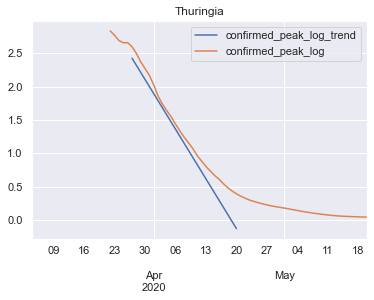

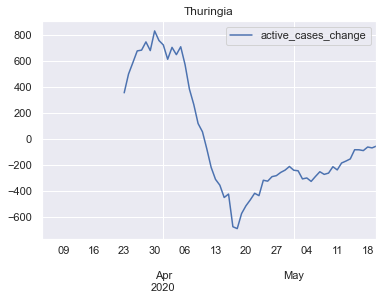

In [50]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_linear(df_ham, 'confirmed_peak_log', ['2020-03-20', '2020-04-05'])
dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
dd.loc[:, ['active_cases_change']].rolling(7).mean().plot(title=l)

In [48]:
df.land.unique()

array(['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hesse', 'Lower Saxony',
       'Mecklenburg-Western Pomerania', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony', 'Saxony-Anhalt',
       'Schleswig-Holstein', 'Thuringia'], dtype=object)

In [195]:
# for l in df.land.unique():
#     df_ham = df.loc[df.land == l].copy()
#     df_ham.drop('peak_log_trend', axis=1, inplace=True)
#     dd = findpeak_trend(df_ham)
#     dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
#     dd.loc[:, ['peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['active_cases_change', 'confirmed_change']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['confirmed_active_cases']].rolling(7).mean().plot(title=l)

In [196]:
# import matplotlib.pyplot as plt
# plt.close('all')

In [8]:
from fbprophet import Prophet
import datetime
import pandas as pd


def add_forecast_prophet(df_in, column, window=60, ):
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame(
        {'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day', inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast], axis=1)
    df_result[f'peak_log_trend'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]

    return df_result


In [ ]:
# dd2 = add_forecast_prophet(df_ham, 'confirmed_peak_log')

In [ ]:
# dd2

In [ ]:
# dd2.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()

In [116]:
import warnings
warnings.filterwarnings("ignore")
def add_trend_arima(df, column, date_range,  days_add=15, start=None):
    if start == None:
        start = df.index.max().date()
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    import statsmodels.api as sm
    mod = sm.tsa.statespace.SARIMAX(y,
#                                     order=(0, 0, 0),
#                                     seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    
    pred_dynamic = results.get_prediction(start=pd.to_datetime(start), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y2 = pred_dynamic.predicted_mean
    y2.rename(f'{column}_trend', inplace=True)
    y2.columns = [f'{column}_trend']
    
    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps=days_add)
    pred_uc = pred_uc.predicted_mean
    pred_uc.rename(f'{column}_trend', inplace=True)
    pred_uc.columns = [f'{column}_trend']
    
#     print(y2,"\n")
#     print(pred_uc,"\n")
    
    print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(15, 12))
#     plt.show()

    df = df.join(y2, how='outer')
    df = pd.merge(df, pred_uc, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
    df[f'{column}_trend'] = df.loc[:, [f'{column}_trend_x', f'{column}_trend_y']].apply(
            lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
    df.drop([f'{column}_trend_x', f'{column}_trend_y'], axis=1, inplace=True)

    return df


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9633      0.017     55.800      0.000       0.929       0.997
sigma2         0.0214      0.011      1.939      0.052      -0.000       0.043


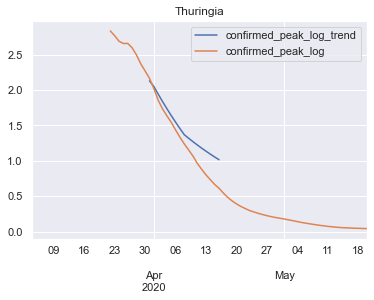

In [117]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, 'confirmed_peak_log', ['2020-03-04', '2020-04-01'], start='2020-03-25')
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5376      0.103      5.233      0.000       0.336       0.739
sigma2      9343.6318    875.467     10.673      0.000    7627.747    1.11e+04


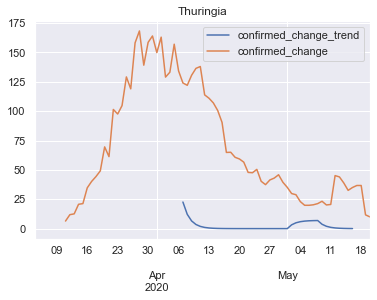

In [122]:
land = 'Hamburg'
column = 'confirmed_change'
df_ham = df.loc[(df.land == land)].copy()
# df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, column, ['2020-03-04', '2020-05-01'], start='2020-04-01')
dd.loc[:, [f'{column}_trend', column]].rolling(7).mean().plot(title=l)

In [162]:
df_jh_world.columns

Index(['state', 'land', 'lat', 'lng', 'iso_code', 'date', 'confirmed',
       'confirmed_avg3', 'confirmed_change', 'confirmed_change_avg3',
       'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days_3w_avg3', 'dead_day_since_10', 

In [161]:
# sorted(df_jh_world.round(3)['confirmed_change_per_100k'], reverse=True)

In [143]:
df_rki_orig['date'] = df_rki_orig['date'].astype('datetime64[ns]')

In [141]:
selected_colum = 'confirmed'

ro = df_rki_orig.groupby('land').rolling(7, on='date').mean().reset_index(drop=False).loc[:,
         ['date', 'land', selected_colum]]
df = df_rki_orig.merge(ro, on=['date', 'land'], suffixes=('', '_weekly')).round(3)

In [200]:
df_apple.head(1)

,date_index,geo_type,region,alternative_name,sub-region,country,date,driving,transit,walking
0,2020-01-13,city,Aachen,NaN,North Rhine-Westphalia,Germany,2020-01-13,100.0,NaN,100.0


In [201]:
df_jh_world.head(1)

,land,iso_code,date,confirmed,confirmed_change,confirmed_change_pct_3w,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k,region_wb
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,Afghanistan,AFG,2020-02-24,1.0,NaN,NaN,NaN,NaN,NaN,-1,371.72,0.00269,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,South Asia


In [203]:
len(df_jh_world.land.unique())

186

In [204]:
len(df_apple.country.unique())

48

In [220]:
df_apple['country'] = df_apple['country'].replace()

In [221]:
list(df_apple.loc[df_apple.country.isin(df_jh_world.land.unique()), 'country'].unique())

['Germany',
 'US',
 'Italy',
 'Australia',
 'Norway',
 'Mexico',
 'Japan',
 'Brazil',
 'Canada',
 'France',
 'Netherlands',
 'Spain',
 'Thailand',
 'Turkey',
 'Chile',
 'Belgium',
 'Greece',
 'New Zealand',
 'United Kingdom',
 'India',
 'Slovakia',
 'Hungary',
 'Switzerland',
 'Sweden',
 'Romania',
 'Argentina',
 'Austria',
 'Korea, South',
 'Egypt',
 'South Africa',
 'Denmark',
 'Morocco',
 'Czechia',
 'Israel',
 'Finland',
 'Taiwan*',
 'Ireland',
 'Indonesia',
 'Luxembourg',
 'United Arab Emirates',
 'Poland',
 'Vietnam',
 'Malaysia',
 'Russia',
 'Portugal',
 'Philippines',
 'Saudi Arabia']

In [222]:
list(df_apple.loc[~df_apple.country.isin(df_jh_world.land.unique()), 'country'].unique())

[nan]

In [ ]:
{'United States': 'US', 'Republic of Korea', 'Korea, South', 'Czech Republic': 'Czechia', 'Taiwan': 'Taiwan*'}

In [213]:
df_jh_world.loc[df_jh_world.land.str.contains('Taiwan')]

,land,iso_code,date,confirmed,confirmed_change,confirmed_change_pct_3w,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k,region_wb
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,Taiwan*,TWN,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-23,Taiwan*,TWN,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-24,Taiwan*,TWN,2020-01-24,3.0,2.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-25,Taiwan*,TWN,2020-01-25,3.0,0.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
2020-01-26,Taiwan*,TWN,2020-01-26,4.0,1.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,East Asia & Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-20,Taiwan*,TWN,2020-05-20,440.0,0.0,0.00,100.0,0.0,0.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific
2020-05-21,Taiwan*,TWN,2020-05-21,440.0,0.0,0.00,100.0,0.0,0.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific
2020-05-22,Taiwan*,TWN,2020-05-22,441.0,1.0,9.09,75.0,1.0,1.0,0,NaN,NaN,NaN,NaN,7.0,0.0,100.0,0.0,NaN,NaN,East Asia & Pacific


In [239]:
df_orig = pd.read_csv("data-processed/rki-reports.csv")


In [240]:
# df_orig.loc[(df_orig.date == '2020-05-24')]

In [241]:
# df_orig.loc[(df_orig.date == '2020-05-24') & (df_orig.confirmed ==9762), 'land'] = 'Hesse'